In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

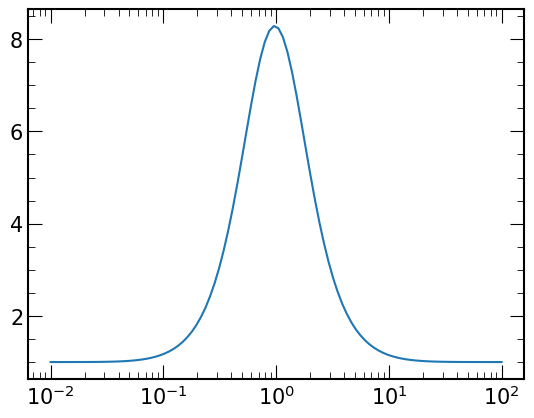

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-e57eb6f857e9>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
10.100281715393066
4 0.1
finished until t = 0.0 1.0982389450073242


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.910995721817017
finished until t = 1.0 15.01570725440979
finished until t = 1.5 25.542732000350952
finished until t = 2.0 38.52852249145508
finished until t = 2.5 53.503721475601196
finished until t = 3.0 70.47631859779358
finished until t = 3.5 89.61907529830933
finished until t = 4.0 110.55732345581055
finished until t = 4.5 133.18985962867737
finished until t = 5.0 160.38303399085999
finished until t = 5.5 189.36885452270508
finished until t = 6.0 220.01364302635193
finished until t = 6.5 252.22578239440918
finished until t = 7.0 285.3627097606659
finished until t = 7.5 320.7182238101959
finished until t = 8.0 355.4174723625183
finished until t = 8.5 391.4198365211487
finished until t = 9.0 428.9280023574829
finished until t = 9.5 470.0156400203705
finished until t = 10.0 512.6559114456177


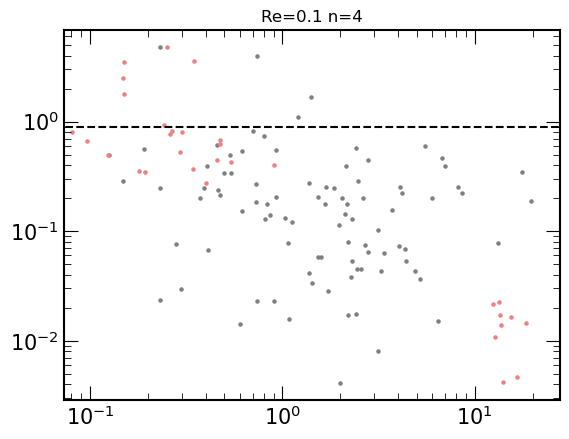

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.667057275772095
4 0.6
finished until t = 0.0 0.7037520408630371
finished until t = 0.5 5.351710557937622
finished until t = 1.0 14.100001811981201
finished until t = 1.5 27.723742723464966
finished until t = 2.0 45.020734786987305
finished until t = 2.5 66.78403282165527
finished until t = 3.0 92.98321914672852
finished until t = 3.5 123.73893141746521
finished until t = 4.0 158.5075080394745
finished until t = 4.5 198.52212977409363
finished until t = 5.0 242.99035573005676
finished until t = 5.5 294.88439202308655
finished until t = 6.0 356.7049446105957
finished until t = 6.5 427.6200387477875
finished until t = 7.0 503.6936285495758
finished until t = 7.5 585.7947797775269
finished until t = 8.0 672.50106549263
finished until t = 8.5 764.4920852184296
finished until t = 9.0 862.6791317462921
finished until t = 9.5 965.8378117084503
finished until t = 10.0 1074.2916979789734


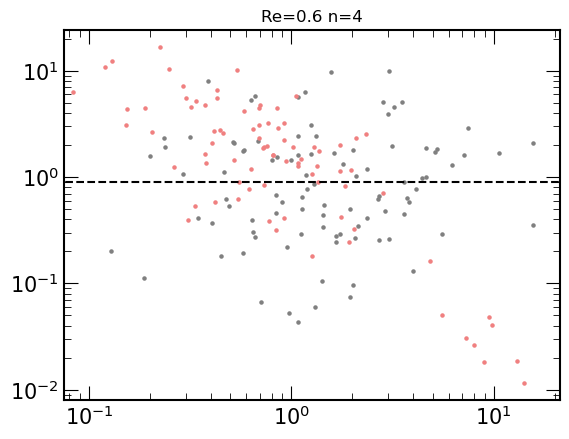

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.674402236938477
4 1.1
finished until t = 0.0 0.810746431350708
finished until t = 0.5 6.538763761520386
finished until t = 1.0 16.701377868652344
finished until t = 1.5 32.20678234100342
finished until t = 2.0 52.738197565078735
finished until t = 2.5 78.504150390625
finished until t = 3.0 109.33566856384277
finished until t = 3.5 145.236736536026
finished until t = 4.0 185.89993381500244
finished until t = 4.5 231.93382382392883
finished until t = 5.0 283.52356457710266
finished until t = 5.5 339.7395558357239
finished until t = 6.0 401.44261598587036
finished until t = 6.5 468.90758776664734
finished until t = 7.0 541.4499258995056
finished until t = 7.5 619.1203861236572
finished until t = 8.0 702.2448086738586
finished until t = 8.5 790.0463621616364
finished until t = 9.0 883.8535492420197
finished until t = 9.5 982.8308181762695
finished until t = 10.0 1086.9417934417725


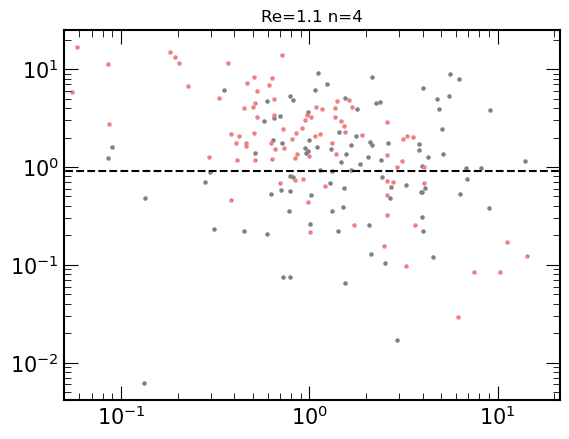

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.151403188705444
4 1.6
finished until t = 0.0 0.7865803241729736
finished until t = 0.5 5.899372816085815
finished until t = 1.0 15.252330303192139
finished until t = 1.5 29.381051063537598
finished until t = 2.0 47.6613564491272
finished until t = 2.5 70.94836068153381
finished until t = 3.0 98.69229388237
finished until t = 3.5 131.0992569923401
finished until t = 4.0 168.39202618598938
finished until t = 4.5 209.9625527858734
finished until t = 5.0 256.5941529273987
finished until t = 5.5 308.0774984359741
finished until t = 6.0 363.9483907222748
finished until t = 6.5 425.1883919239044
finished until t = 7.0 491.69578289985657
finished until t = 7.5 562.8856387138367
finished until t = 8.0 639.5022902488708
finished until t = 8.5 720.5905680656433
finished until t = 9.0 805.8552722930908
finished until t = 9.5 896.0690898895264
finished until t = 10.0 990.8713848590851


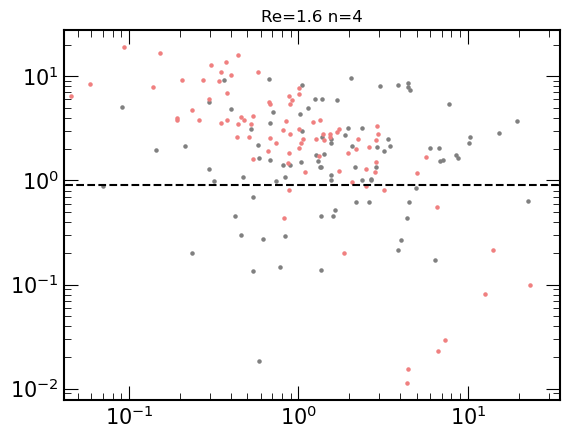

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.786172866821289
4 2.1
finished until t = 0.0 0.8479568958282471
finished until t = 0.5 7.332308530807495
finished until t = 1.0 18.699037551879883
finished until t = 1.5 35.947344064712524
finished until t = 2.0 58.194684743881226
finished until t = 2.5 86.03373098373413
finished until t = 3.0 119.40164422988892
finished until t = 3.5 158.82524824142456
finished until t = 4.0 203.55310440063477
finished until t = 4.5 253.96038484573364
finished until t = 5.0 310.347393989563
finished until t = 5.5 371.44586205482483
finished until t = 6.0 438.53347659111023
finished until t = 6.5 510.8162474632263
finished until t = 7.0 587.6183788776398
finished until t = 7.5 669.7584629058838
finished until t = 8.0 756.8114941120148
finished until t = 8.5 848.8050887584686
finished until t = 9.0 946.7392268180847
finished until t = 9.5 1049.3443655967712
finished until t = 10.0 1156.9402713775635


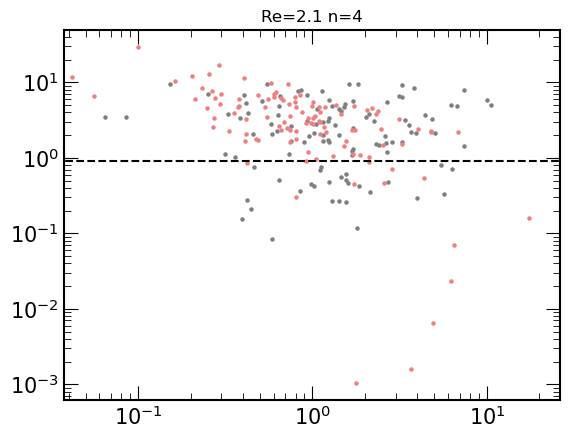

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.38403058052063
4 2.6
finished until t = 0.0 0.8160316944122314
finished until t = 0.5 6.5303568840026855
finished until t = 1.0 17.821701049804688
finished until t = 1.5 33.997679471969604
finished until t = 2.0 55.50925326347351
finished until t = 2.5 81.8891031742096
finished until t = 3.0 113.70490527153015
finished until t = 3.5 150.40552759170532
finished until t = 4.0 192.3086416721344
finished until t = 4.5 239.40481781959534
finished until t = 5.0 292.4428246021271
finished until t = 5.5 350.5224666595459
finished until t = 6.0 414.3118667602539
finished until t = 6.5 483.21933245658875
finished until t = 7.0 558.1010119915009
finished until t = 7.5 638.6386163234711
finished until t = 8.0 724.7048487663269
finished until t = 8.5 815.3235743045807
finished until t = 9.0 910.9348783493042
finished until t = 9.5 1012.7380864620209
finished until t = 10.0 1118.896938085556


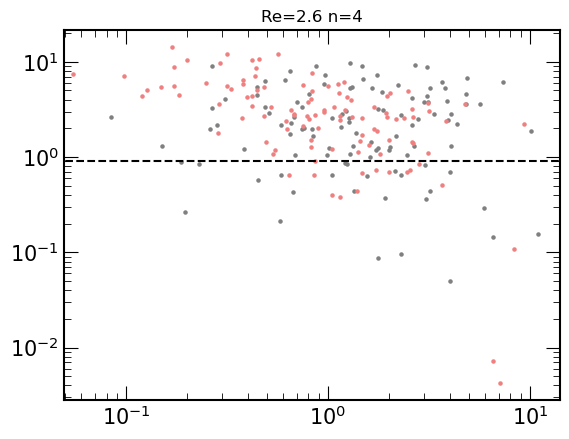

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.00625228881836
4 3.1
finished until t = 0.0 0.7627706527709961
finished until t = 0.5 5.693386793136597
finished until t = 1.0 14.581406593322754
finished until t = 1.5 27.5783474445343
finished until t = 2.0 44.45981049537659
finished until t = 2.5 65.56376600265503
finished until t = 3.0 90.66128635406494
finished until t = 3.5 120.08865308761597
finished until t = 4.0 153.80739831924438
finished until t = 4.5 191.45938301086426
finished until t = 5.0 232.4987771511078
finished until t = 5.5 273.97565937042236
finished until t = 6.0 319.3967111110687
finished until t = 6.5 368.1913902759552
finished until t = 7.0 421.1083128452301
finished until t = 7.5 477.8622839450836
finished until t = 8.0 537.7066180706024
finished until t = 8.5 601.798907995224
finished until t = 9.0 669.472963809967
finished until t = 9.5 741.4858102798462
finished until t = 10.0 817.1967289447784


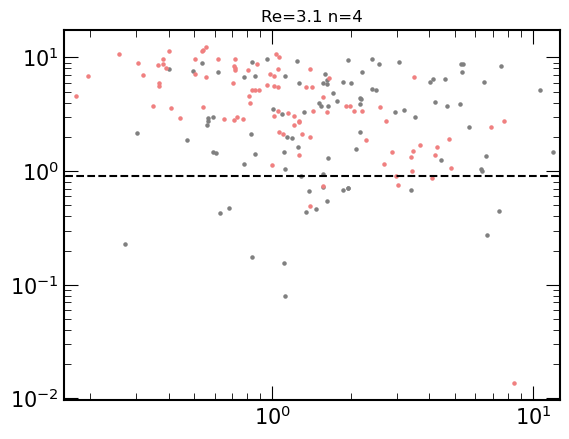

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.41775918006897
4 3.6
finished until t = 0.0 0.7210185527801514
finished until t = 0.5 5.71955132484436
finished until t = 1.0 15.311107873916626
finished until t = 1.5 29.277425527572632
finished until t = 2.0 48.20022749900818
finished until t = 2.5 71.09767198562622
finished until t = 3.0 99.21506786346436
finished until t = 3.5 131.4952793121338
finished until t = 4.0 168.4020483493805
finished until t = 4.5 209.9418375492096
finished until t = 5.0 255.92276167869568
finished until t = 5.5 306.02621507644653
finished until t = 6.0 357.8060097694397
finished until t = 6.5 411.4275619983673
finished until t = 7.0 469.23204612731934
finished until t = 7.5 530.890870809555
finished until t = 8.0 597.1847312450409
finished until t = 8.5 667.7871870994568
finished until t = 9.0 742.9105136394501
finished until t = 9.5 821.8806307315826
finished until t = 10.0 902.4863140583038


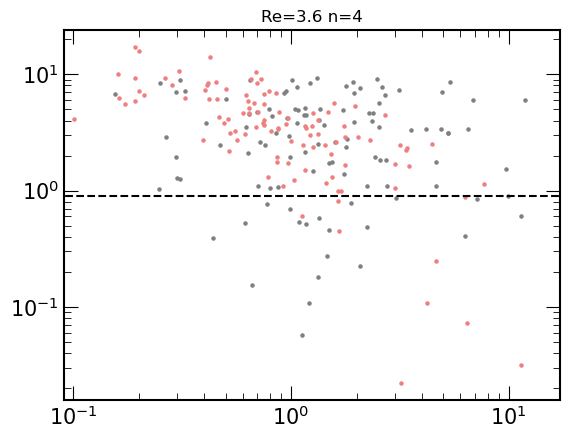

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.0919349193573
4 4.1
finished until t = 0.0 0.5570907592773438
finished until t = 0.5 3.962934732437134
finished until t = 1.0 10.226643800735474
finished until t = 1.5 19.201748847961426
finished until t = 2.0 31.09374475479126
finished until t = 2.5 45.74053764343262
finished until t = 3.0 63.208329916000366
finished until t = 3.5 83.66334438323975
finished until t = 4.0 107.06075930595398
finished until t = 4.5 133.39018297195435
finished until t = 5.0 162.6553041934967
finished until t = 5.5 194.83687663078308
finished until t = 6.0 229.82765984535217
finished until t = 6.5 267.6963016986847
finished until t = 7.0 308.2345368862152
finished until t = 7.5 346.8097970485687
finished until t = 8.0 387.72713685035706
finished until t = 8.5 431.5334117412567
finished until t = 9.0 477.5685656070709
finished until t = 9.5 526.8292551040649
finished until t = 10.0 579.2351424694061


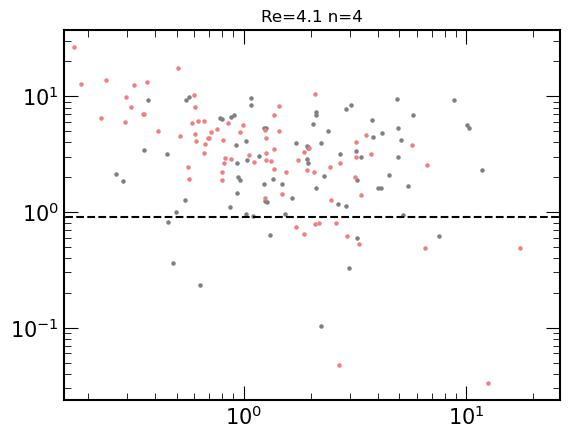

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.422659397125244
4 4.6
finished until t = 0.0 0.5738091468811035
finished until t = 0.5 4.372281789779663
finished until t = 1.0 11.438467979431152
finished until t = 1.5 21.722411632537842
finished until t = 2.0 35.274574279785156
finished until t = 2.5 52.078901529312134
finished until t = 3.0 72.03533935546875
finished until t = 3.5 95.12818932533264
finished until t = 4.0 121.51709914207458
finished until t = 4.5 151.18684363365173
finished until t = 5.0 184.20296001434326
finished until t = 5.5 220.89067888259888
finished until t = 6.0 260.91103959083557
finished until t = 6.5 304.1289565563202
finished until t = 7.0 350.46535992622375
finished until t = 7.5 399.9373059272766
finished until t = 8.0 452.9200677871704
finished until t = 8.5 507.0295548439026
finished until t = 9.0 559.5449733734131
finished until t = 9.5 614.9603416919708
finished until t = 10.0 672.455260515213


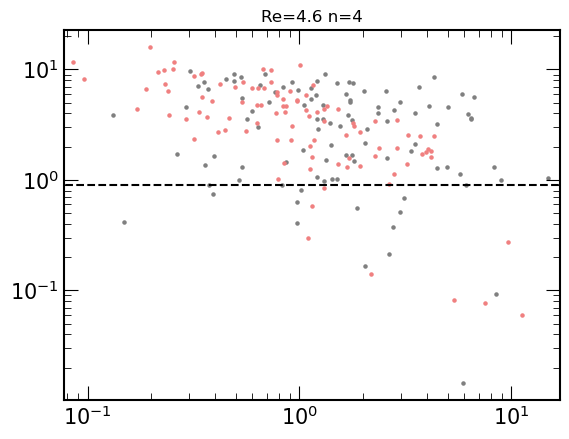

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.226919412612915
4 5.1
finished until t = 0.0 0.44028139114379883
finished until t = 0.5 3.398177146911621
finished until t = 1.0 9.012769937515259
finished until t = 1.5 17.18374752998352
finished until t = 2.0 27.909577131271362
finished until t = 2.5 41.19574284553528
finished until t = 3.0 57.01132106781006
finished until t = 3.5 75.54014205932617
finished until t = 4.0 97.15772128105164
finished until t = 4.5 121.46820092201233
finished until t = 5.0 148.5106520652771
finished until t = 5.5 177.54061698913574
finished until t = 6.0 209.69424152374268
finished until t = 6.5 244.95380425453186
finished until t = 7.0 283.01394987106323
finished until t = 7.5 322.96815061569214
finished until t = 8.0 364.8220660686493
finished until t = 8.5 409.3829011917114
finished until t = 9.0 456.5935287475586
finished until t = 9.5 506.6014759540558
finished until t = 10.0 559.4043076038361


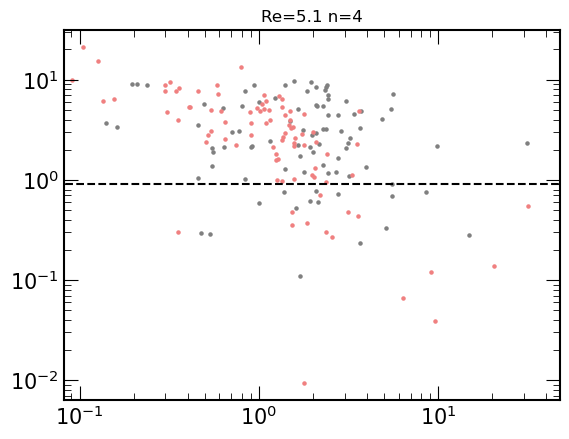

In [3]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [4]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [3]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
14.092623233795166
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
13.688145875930786


In [4]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [4]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [5]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 2.2727572917938232
finished until t = 0.5 94.19441652297974
finished until t = 1.0 286.69045329093933
finished until t = 1.5 566.6148314476013
finished until t = 2.0 935.7081272602081
finished until t = 2.5 1391.1465148925781
finished until t = 3.0 1935.4917051792145
finished until t = 3.5 2567.5902650356293
finished until t = 4.0 3288.5142443180084
finished until t = 4.5 4096.751589775085
finished until t = 5.0 4994.229481220245
finished until t = 5.5 5979.199592590332
finished until t = 6.0 7044.558765411377
finished until t = 6.5 8187.4064955711365
finished until t = 7.0 9414.309736967087
finished until t = 7.5 10720.99087691307
finished until t = 8.0 12115.244203805923
finished until t = 8.5 13590.31358385086
finished until t = 9.0 15160.328066587448
finished until t = 9.5 16812.60069322586
finished until t = 10.0 18342.86258125305


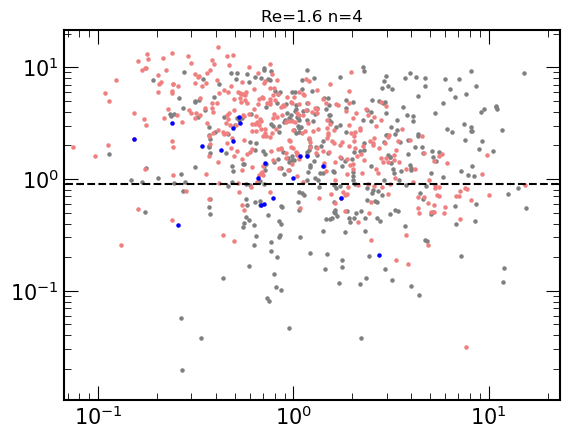

finished until t = 0.0 1.698896884918213
finished until t = 0.5 78.532874584198
finished until t = 1.0 229.28739953041077
finished until t = 1.5 453.9678120613098
finished until t = 2.0 751.2971661090851
finished until t = 2.5 1120.9185376167297
finished until t = 3.0 1561.8826801776886
finished until t = 3.5 2074.3913843631744
finished until t = 4.0 2657.760209798813
finished until t = 4.5 3312.717975616455
finished until t = 5.0 4039.3668456077576
finished until t = 5.5 4836.085361480713
finished until t = 6.0 5703.063614606857
finished until t = 6.5 6641.666356563568
finished until t = 7.0 7650.1696672439575
finished until t = 7.5 8725.535937547684
finished until t = 8.0 9870.991195440292
finished until t = 8.5 11086.821106672287
finished until t = 9.0 12369.30569934845
finished until t = 9.5 13632.64646935463
finished until t = 10.0 14705.32421207428


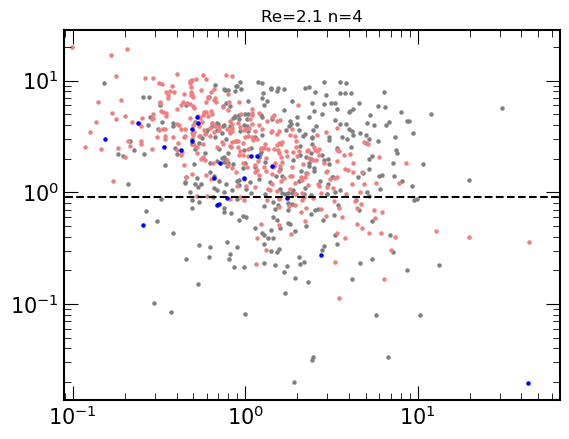

In [6]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 2.4928486347198486
finished until t = 0.5 24.147404432296753
finished until t = 1.0 63.15305972099304
finished until t = 1.5 116.80226802825928


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 2.0 184.97546362876892
finished until t = 2.5 273.75973892211914
finished until t = 3.0 385.65790915489197
finished until t = 3.5 513.7033998966217
finished until t = 4.0 656.2850756645203
finished until t = 4.5 812.9914970397949
finished until t = 5.0 983.7869420051575
finished until t = 5.5 1168.097156047821
finished until t = 6.0 1365.4736759662628
finished until t = 6.5 1576.4711492061615
finished until t = 7.0 1800.1038446426392
finished until t = 7.5 2035.3796405792236
finished until t = 8.0 2281.5516741275787
finished until t = 8.5 2539.1840240955353
finished until t = 9.0 2811.060708999634
finished until t = 9.5 3087.403965950012
finished until t = 10.0 3356.4460368156433


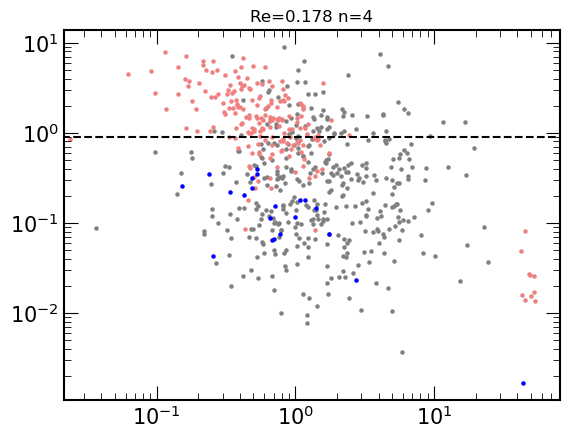

finished until t = 0.0 1.7191238403320312
finished until t = 0.5 24.13072109222412
finished until t = 1.0 67.34473133087158
finished until t = 1.5 129.83344984054565
finished until t = 2.0 210.82399368286133
finished until t = 2.5 308.9146213531494
finished until t = 3.0 423.74525237083435
finished until t = 3.5 555.0166127681732
finished until t = 4.0 701.6309201717377
finished until t = 4.5 863.0637311935425
finished until t = 5.0 1040.2307686805725
finished until t = 5.5 1231.2067012786865
finished until t = 6.0 1420.3138527870178
finished until t = 6.5 1618.9340994358063
finished until t = 7.0 1811.2576484680176
finished until t = 7.5 1982.8952519893646
finished until t = 8.0 2162.4532659053802
finished until t = 8.5 2344.920879125595
finished until t = 9.5 2731.9769189357758
finished until t = 10.0 2934.0320653915405


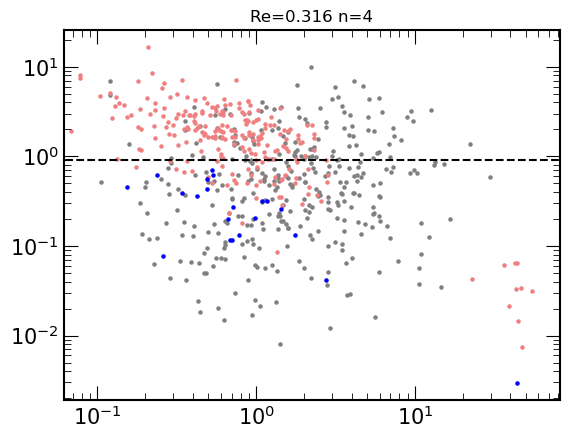

In [7]:
#NFW
R_e_values = [0.178, 0.316]
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        


        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
    